In [4]:
# pip install chromadb

In [3]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

embedding_function = OpenAIEmbeddings()

docs = [
    Document(
        page_content="Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.",
        metadata={"source": "about.txt"}
    ),
    Document(
        page_content="Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.",
        metadata={"source": "hours.txt"}
    ),
    Document(
        page_content="Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining.",
        metadata={"source": "membership.txt"}
    ),
    Document(
        page_content="Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. The full schedule is available on our mobile app or at the reception desk.",
        metadata={"source": "classes.txt"}
    ),
    Document(
        page_content="Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training. Personal training sessions can be booked individually (₹800/session) or in packages of 10 (₹7,000) or 20 (₹13,000).",
        metadata={"source": "trainers.txt"}
    ),
    Document(
        page_content="Peak Performance Gym's facilities include a cardio zone with 30+ machines, strength training area, functional fitness space, dedicated yoga studio, spin class room, swimming pool (25m), sauna and steam rooms, juice bar, and locker rooms with shower facilities. Our equipment is replaced or upgraded every 3 years to ensure members have access to the latest fitness technology.",
        metadata={"source": "facilities.txt"}
    )
]

db = Chroma.from_documents(docs, embedding_function)

In [5]:
retreiver = db.as_retriever(search="mmr", search_kwargs={"k":3})

In [6]:
retreiver.invoke("Who founded the gym and what are the timings")

[Document(metadata={'source': 'hours.txt'}, page_content='Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.'),
 Document(metadata={'source': 'about.txt'}, page_content='Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.'),
 Document(metadata={'source': 'classes.txt'}, page_content='Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are schedu

In [7]:
from langchain.prompts import ChatPromptTemplate

template = """
Answer the question based only on the following context: {context}
Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

## 1. basic implementation

In [10]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

qa_chain = (
    {
        "context":lambda x: format_docs(retreiver.invoke(x)),
        "question": lambda x: x
    }
    | prompt
    | llm 
    | StrOutputParser()
)
qa_chain.invoke("Who is the owner and what are the timings?")

'The owner of Peak Performance Gym is Marcus Chen. The gym is open Monday through Friday from 5:00 AM to 11:00 PM and on weekends from 7:00 AM to 9:00 PM. Members with Premium access can enter 24/7, including holidays.'

## 2. Classification driven retrieval system

In [11]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

def format_docs():
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = prompt | llm 

In [12]:
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage
from langchain.schema import Document
from langgraph.graph import StateGraph
from typing import TypedDict, Annotated

class AgentState(TypedDict):
    messages: list[BaseMessage]
    documents: list[Document]
    on_topic: str

**Field** is a Pydantic function that lets you provide extra metadata for the field, such as:
description → explains the field’s purpose
default → a default value
example → a sample value
Validation rules (e.g., max_length, regex, ge, le)

In [29]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

class GradeQuestion(BaseModel):
    """ Returns Boolean value whether a question relevant to the current topic """
    score: str = Field(description="Question is about gym? if yes -> 'Yes' if not -> 'No")

def question_classifier(state: AgentState):
    question = state["messages"][-1].content # human message
    system = """ You are a classifier that determines whether a user's question is about one of the following topics 
    
    1. Gym History & Founder
    2. Operating Hours
    3. Membership Plans 
    4. Fitness Classes
    5. Personal Trainers
    6. Facilities & Equipment
    
    If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.

    """

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "User question: {question}")
        ]
    )


    llm = ChatOpenAI(model = "gpt-4o")
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({"question": question})
    state["on_topic"] = result.score
    return state

rag_chain returns something like this : {
    "role": "assistant",
    "content": "The gym is open from 6am to 10pm every day."
}

In [30]:
def on_topic_router(state: AgentState):
    on_topic = state["on_topic"]
    if on_topic.lower()=="yes":
        return "on_topic"
    return "off_topic"

def retrieve(state: AgentState):
    question = state["messages"][-1].content
    documents = retreiver.invoke(question)
    state['documents'] = documents
    return state

def generate_answer(state: AgentState):
    question = state['messages'][-1].content
    documents = state["documents"]
    generation = rag_chain.invoke({"context":documents, "question":question})
    state["messages"].append(generation)
    

def off_topic_response(state: AgentState):
    state["messages"].append(AIMessage(content="I'm sorry! I cannot answer this question!"))
    return state

In [31]:
from langgraph.graph import StateGraph, END
workflow = StateGraph(AgentState)

workflow.add_node("topic_decision",question_classifier)
workflow.add_node("off_topic_response",off_topic_response)
workflow.add_node("retrieve",retrieve)
workflow.add_node("generate_answer",generate_answer)
workflow.set_entry_point("topic_decision")

workflow.add_edge("retrieve","generate_answer")
workflow.add_edge("off_topic_response",END)
workflow.add_edge("generate_answer",END)
workflow.add_conditional_edges("topic_decision",on_topic_router,{"on_topic":"retrieve","off_topic":"off_topic_response"})

graph = workflow.compile()

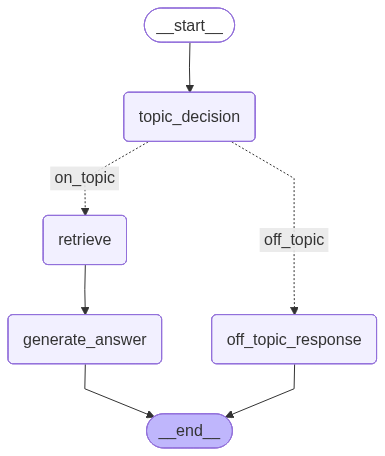

In [32]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [33]:
user_question = "Who is the owner and what are the timings"

graph.invoke(input={
    "messages":[HumanMessage(content=user_question)]
})

{'messages': [HumanMessage(content='Who is the owner and what are the timings', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The owner of Peak Performance Gym is former Olympic athlete Marcus Chen. The gym is open Monday through Friday from 5:00 AM to 11:00 PM, and on weekends from 7:00 AM to 9:00 PM. It is closed on major national holidays, but members with Premium access can enter 24/7, including holidays.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 282, 'total_tokens': 354, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_deacdd5f6f', 'finish_reason': 'stop', 'logprobs': None}, id='run-56fad24f-6c43-434b-b154-77da01d11886-0', usage_metadata={'input_tokens': 282, 'output_tokens'

In [34]:
user_question = "What are the latest Apple company products"

graph.invoke(input={
    "messages":[HumanMessage(content=user_question)]
})

{'messages': [HumanMessage(content='What are the latest Apple company products', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm sorry! I cannot answer this question!", additional_kwargs={}, response_metadata={})],
 'on_topic': 'No'}

## 3. Providing RAG as a node